<a href="https://colab.research.google.com/github/Nathan-Roll1/ProsodPy/blob/main/Tutorials/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
try:
  shutil.rmtree('ProsodPy')
except:
  pass
!git clone https://github.com/Nathan-Roll1/ProsodPy

import ProsodPy.ProsodPy as PP
from tqdm import tqdm

Cloning into 'ProsodPy'...
remote: Enumerating objects: 303, done.
remote: Counting objects: 100% (127/127), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 303 (delta 43), reused 100 (delta 31), pack-reused 176
Receiving objects: 100% (303/303), 46.97 MiB | 15.98 MiB/s, done.
Resolving deltas: 100% (113/113), done.


In [ ]:
# install backwards compatible version of Tensorflow ----------
# this can take a little bit...
!pip install tensorflow==2.7.0
import tensorflow as tf
print(tf.__version__)
#--------------------------------------------------------------

In [3]:
# define MFCC segments for train/test purposes ---------------
set_indices = {'pre':'[:,:512]',
               'h_pre':'[:,256:512]',
               'bound':'[:,lower_mid:upper_mid]',
               'h_bound':'[:,lower_mid+128:upper_mid-128]',
               'post':'[:,-512:][:,::-1]',
               'h_post':'[:,-256:][:,::-1]'}
#--------------------------------------------------------------

In [4]:
# load feed order for OLS -------------------------------------
with open('ProsodPy/Models/Metadata/feed_order.pickle', 'rb') as handle:
  feed_order = PP.pickle.load(handle)
#--------------------------------------------------------------

In [5]:
# load NNs
models = PP.os.listdir('ProsodPy/Models/Model Files')

In [6]:
# load OLS model
with open('ProsodPy/Models/Model Files/OLS.pickle', 'rb') as handle:
  OLS = PP.pickle.load(handle)

In [7]:
# specify boundary break point
h = 512

# ... and 1/4|3/4 points
lower_mid, upper_mid = int(h-h/2),int(h+h/2)

# Generate Predicted Boundaries

In [8]:
# load test file --------------------------------------------
import urllib.request

# if remote, specify path to audio file
audio_path = 'https://www2.cs.uic.edu/~i101/SoundFiles/gettysburg.wav'

# download sample audio file
urllib.request.urlretrieve(audio_path, 'gettysburg.wav')

# load the audio array with a sample rate of 8 kHz
audio_array = PP.librosa.load('gettysburg.wav',sr=8000)[0]
# -----------------------------------------------------------

In [9]:
# generate MFCC and potential (heuristic) boundaries (dont change parameters!!)
boundary_mfcc, __, boundaries = PP.MFCC_preprocess(
    audio_array, PP.np.array([0]), hop_length=16, n_mfcc = 15, n_fft=743, n_frames = 1024
    )

# shift axes
boundary_mfcc = boundary_mfcc.transpose(0,2,1)
# ------------------------------------------------------------------------------

In [10]:
# make inferences on CNNs and RNNs ---------------------------------------------

# initialize prediction dictionary
outputs_dict = {}

# for each MFCC subset...
for k, s in tqdm(set_indices.items()):

  # get the corresponding RNN & CNN
  mods = [x for x in models if (k in x)&(not f'h_{k}' in x)]

  # for each of those models...
  for m in mods:

    # load the model
    r = tf.keras.models.load_model(f'ProsodPy/Models/Model Files/{m}')

    # generate inference and add to prediction dictionary
    if 'cnn' in m:
      t = 'cnn'
      outputs_dict[f'{k}_{t}'] = r.predict(PP.np.expand_dims(eval(f'boundary_mfcc{s}'),3))
    else:
      t = 'rnn'
      outputs_dict[f'{k}_{t}'] = r.predict(eval(f'boundary_mfcc{s}'))
# ------------------------------------------------------------------------------

100%|██████████| 6/6 [00:20<00:00,  3.36s/it]


In [11]:
# create prediction dataframe --------------------------------------------------

# initialize DF
df = PP.pd.DataFrame()

# add each prediction set to the data frame
for c,d in outputs_dict.items():
  df[c] = [x[0] for x in d]

# index DF at boundary position
df.index = boundaries
# ------------------------------------------------------------------------------

In [12]:
# make predictions
df['pred'] = OLS.predict(df[feed_order].values)

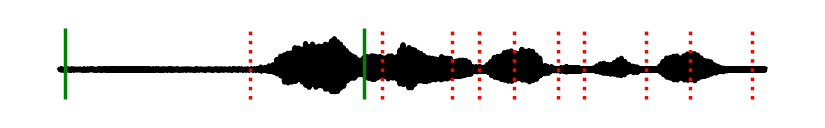

In [13]:
# plot predictions on subset
PP.waveform_plot(audio_array, boundaries, df, i=5, threshold = 0.5)

In [14]:
# export predictions to csv ----------------------------------------------------

# get prediction column from dataframe
output = df['pred']

# timestamp back into seconds
output.index = output.index/8000

# save to path
PP.pd.DataFrame(output).to_csv('boundaries.csv')
# ------------------------------------------------------------------------------